## Loading data

In [191]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [192]:
DATA_DIR = './spills_segm_dataset/'

In [193]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_annot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_annot')

In [287]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), color = 'white')
        plt.imshow(image)
    plt.show()

### Dataloader

In [195]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [225]:
class Dataset(BaseDataset):
    """OIL Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'oil']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id + '.jpg') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
#         print(self.masks_fps)
        data =  np.load(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i], 0)
        if not os.path.exists(self.masks_fps[i]):
            print(self.masks_fps[i])
#         print(self.images_fps[i])
#         print(self.masks_fps[i])
#         print(image.shape)
#         print(mask.shape)
        _, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
        mask = mask//255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        data = data.transpose(2, 0, 1).astype('float32')
        mask = mask.transpose(2, 0, 1).astype('float32')
#         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
        
        
            
        return data, mask
        
    def __len__(self):
        return len(self.ids)

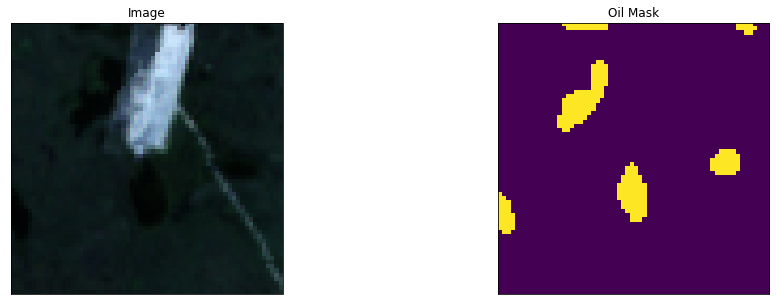

In [226]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['oil'])

data, mask = dataset[10]
image = (data[1:4,:,:]/np.amax(data[1:4,:,:])).transpose(1, 2, 0)
visualize(
    image=image, 
    oil_mask=mask.squeeze(),
)

In [227]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Create model and train

In [228]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [229]:
ENCODER = 'timm-efficientnet-b1'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['oil']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [230]:
model.encoder.conv_stem = torch.nn.Conv2d(19, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [231]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [232]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.DiceLoss()
loss = smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [233]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [253]:
# train model for 40 epochs

max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_satelite.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00, 42.55it/s, bce_loss - 0.08414, iou_score - 0.5]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00, 42.05it/s, bce_loss - 0.0843, iou_score - 0.5214]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00, 39.22it/s, bce_loss - 0.08162, iou_score - 0.5423]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00, 42.55it/s, bce_loss - 0.08528, iou_score - 0.5405]

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00, 44.44it/s, bce_loss - 0.08615, iou_score - 0.5347]

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00, 42.55it/s, bce_loss - 0.08273, iou_score - 0.5357]

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00, 37.04it/s, bce_loss - 0.08164, iou_score - 0.5405]

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00, 45.45it/s, bce_loss - 0.07916, iou_score - 0.5]

Epoch: 8
valid: 100%|██████████| 2/2 [00:00<00:00, 42.55it/s, bce_loss - 0.08065, iou_score - 0.5]

Epoch: 9
valid: 100%|██████████| 2/2 [00:00

## Test best saved model

In [296]:
# load best saved checkpoint
best_model = torch.load('./best_model_satelite.pth')

In [297]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [298]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 2/2 [00:00<00:00, 41.66it/s, bce_loss - 0.1606, iou_score - 0.7643]


## Visualize predictions

In [299]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

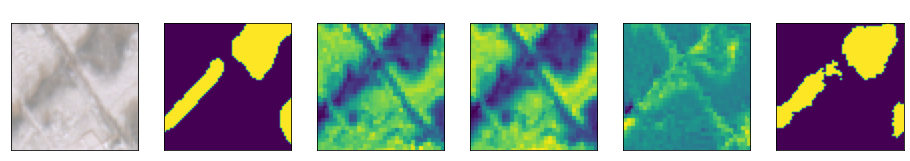

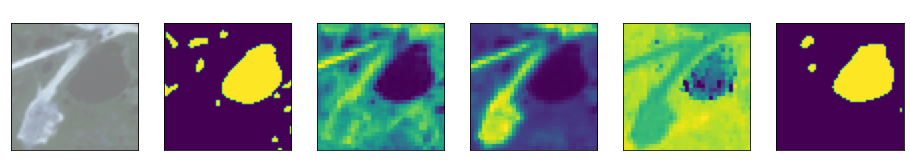

In [300]:
for i in range(2):
    n = np.random.choice(len(test_dataset))
    
    data, gt_mask = test_dataset[n]
    image = (data[1:4,:,:]/np.amax(data[1:4,:,:])).transpose(1, 2, 0)
    b5 = data[5,:,:]
    b11 = data[11,:,:]
    ndvi = (data[8,:,:] - data[4,:,:])/(data[8,:,:] + data[4,:,:])
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(data).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    image = image * 0.5 + 0.5
    visualize(
        image=image, 
        ground_truth_mask=gt_mask,
        b5 = b5,
        b11 = b11,
        ndvi = ndvi,
        predicted_mask=pr_mask
    )

## Square definition

In [285]:
np.unique(pr_mask, return_counts=True)

(array([0., 1.], dtype=float32), array([3136,  960], dtype=int64))

In [303]:
ONE_PIX_SQUARE = 10
oil_square = ONE_PIX_SQUARE * pr_mask.sum()

In [304]:
print(f'Площадь розлива: {oil_square:.2f} м. кв.')

Площадь розлива: 6740.00 м. кв.


## Countour to map

In [290]:
contours, _ = cv2.findContours(pr_mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygons = []

contours_sizes= [(cv2.contourArea(cnt), cnt) for cnt in contours]
biggest_contour = max(contours_sizes, key=lambda x: x[0])[1]


In [291]:
biggest_contour[0:5]

array([[[46, 11]],

       [[45, 12]],

       [[44, 12]],

       [[43, 12]],

       [[42, 12]]], dtype=int32)